In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error

from typing import List, Tuple, Optional

from keras.metrics import mean_squared_error, mean_absolute_error
from keras.layers import Dense, LSTM, Input
from keras.models import Sequential, save_model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, History

from datetime import datetime
import json
import os

import scipy.stats as stats

2024-06-08 08:13:27.262448: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 08:13:27.568096: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-08 08:13:28.354928: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-08 08:13:35.355272: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Data Preparation

In [2]:
def data_prep(raw_data_path: str = None,
              price_column: str = 'Close_gold') -> pd.DataFrame:
    
    """
    Prepares the data by calculating the percentage change and log returns for the gold price.

    Args:
        path (str): The file path to the CSV file containing the gold price data.
        price_column (str): The column name for the gold price data in the CSV file.

    Returns:
        pd.DataFrame: DataFrame with percentage change and log returns calculated for the gold price.
    """
    
    if raw_data_path is None:
        raise ValueError("Raw data file path must be provided")
    
    try:
        df = pd.read_csv(raw_data_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"File not found at {raw_data_path}")
    except pd.errors.EmptyDataError:
        raise pd.errors.EmptyDataError("File is empty")
    except pd.errors.ParserError:
        raise ValueError("File is not in CSV format")
    
    if price_column not in df.columns:
        raise ValueError(f"Column {price_column} not found in the DataFrame")
    
    #calculate the percentage change
    #df['returns'] = df['Close_gold'].pct_change()
    #calculate the log returns
    #https://quantivity.wordpress.com/2011/02/21/why-log-returns/
    df['log_returns'] = np.log(1 + df['returns'])
    
    #drop rows with missing values
    df = df.dropna(how='any')
    
    return df

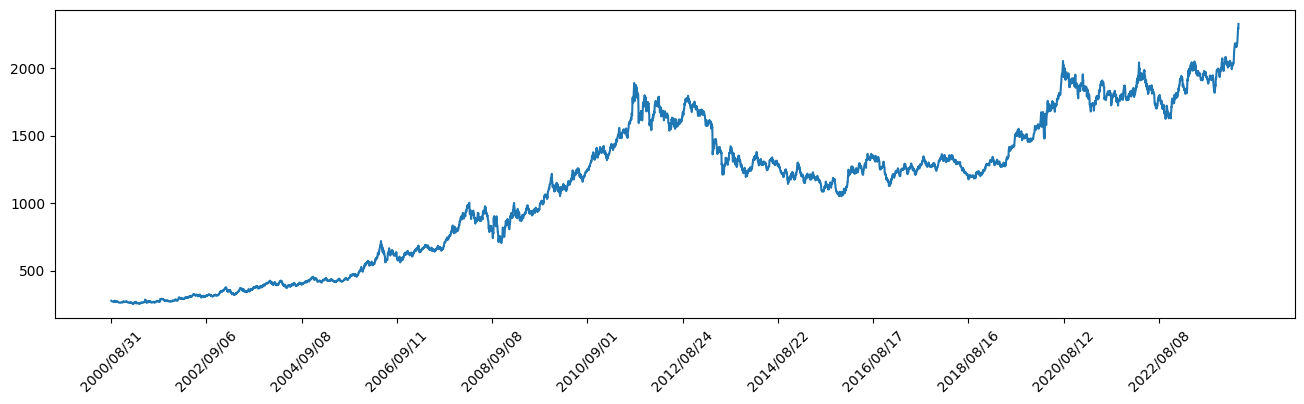

In [3]:
df = data_prep(raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')
plt.figure(figsize=(16, 4))
plt.plot(df['Close_gold'])
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.show();

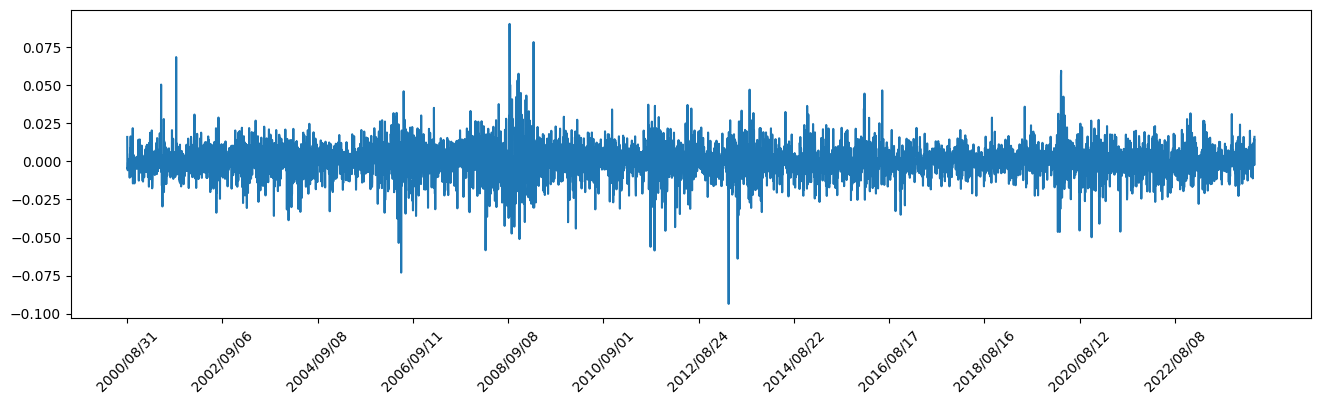

In [20]:
df = data_prep(raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')
plt.figure(figsize=(16, 4))
plt.plot(df['returns'])
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.show();

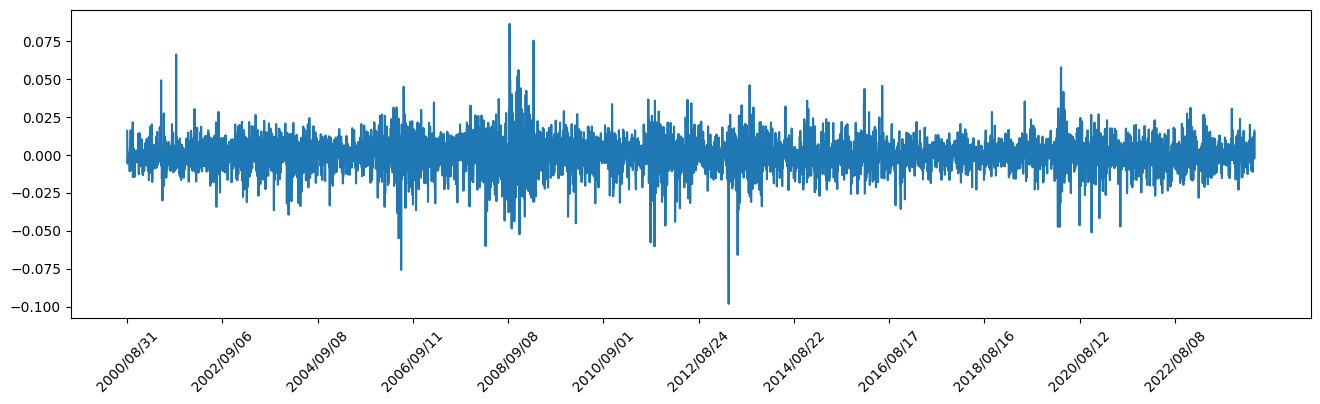

In [22]:
df = data_prep(raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')
plt.figure(1, figsize=(16,4))
plt.plot(df['log_returns'])
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.show();

Feature Building

In [4]:
def feature_prep(df: pd.DataFrame = None,
                 raw_data_path: str = None,
                 columns: List[str] = ['Close_gold', 'log_returns'],
                 p1: float = 0.8,
                 p2: float = 0.95,
                 label_size: int = 3) -> Tuple[np.ndarray, np.ndarray, np.ndarray,
                                      np.ndarray, np.ndarray, np.ndarray,
                                      MinMaxScaler, int, int, int]:
    
    """
    Prepares the features and target vectors for machine learning models, specifically for LSTM.

    Args:
        df (pd.DataFrame): The input DataFrame. If None, it will be created using data_prep().
        raw_data_path (str): The file path to the CSV file containing the gold price data.
        columns (List[str]): The columns to be used for feature preparation.
        p1 (float): The proportion for the first split (training set).
        p2 (float): The proportion for the second split (validation set).
        label_size (int): Number of previous time steps to use as features.

    Returns:
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, MinMaxScaler, int, int, int]: 
        Contains training, validation, and test sets for features and labels, the scaler used for normalization, the label size, split_1 and split_2.
    """
    
    if df is None:
        if raw_data_path is None:
            raise ValueError("Raw data file path must be provided")
        df = data_prep(raw_data_path = raw_data_path)
        
    #create feature matrix X
    X = df[columns].values
    
    #data normalization with MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X)
    X_scaled = scaler.transform(X)

    #create target vector y
    y = [x[0] for x in X_scaled]
    
    #data split into train, test and validation sets
    split_1 = int(len(X_scaled) * p1)
    split_2 = int(len(X_scaled) * p2)

    X_train = X_scaled[:split_1]
    X_validation = X_scaled[split_1 : split_2]
    X_test = X_scaled[split_2:]
    y_train = y[:split_1]
    y_validation = y[split_1 : split_2]
    y_test = y[split_2:]
    
    #labeling
    n = label_size
    Xtrain, ytrain = [], []
    Xvalidation, yvalidation = [], []
    Xtest, ytest = [], []
    
    for i in range(n, len(X_train)):
        Xtrain.append(X_train[i - n: i, : X_train.shape[1]])
        ytrain.append(y_train[i])
    for i in range(n, len(X_test)):
        Xtest.append(X_test[i - n: i, : X_test.shape[1]])
        ytest.append(y_test[i])
    for i in range(n,len(X_validation)):
        Xvalidation.append(X_validation[i - n: i, : X_validation.shape[1]])
        yvalidation.append(y_validation[i])
        
    #LSTM inputs reshaping
    Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
    Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

    Xvalidation, yvalidation = (np.array(Xvalidation), np.array(yvalidation))
    Xvalidation = np.reshape(Xvalidation, (Xvalidation.shape[0], Xvalidation.shape[1], Xvalidation.shape[2]))

    Xtest, ytest = (np.array(Xtest), np.array(ytest))
    Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))
        
    return Xtrain, ytrain, Xvalidation, yvalidation, Xtest, ytest, scaler, label_size, split_1, split_2

In [5]:
Xtrain, ytrain, Xvalidation, yvalidation, Xtest, ytest, scaler, label_size, split_1, split_2 = feature_prep(raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

In [6]:
#revers transformation ex. check
val = np.array(ytrain[0])
val = np.c_[val, np.zeros(val.shape)]
result = scaler.inverse_transform(val)
result

array([[ 2.74200012e+02, -9.82057917e-02]])

Model

In [7]:
def build_3l_model(lstm_nodes_1: int = 10, lstm_nodes_2: int = 20, lstm_nodes_3: int = 20, dense_nodes_1: int = 20,
                   input_shape: Tuple[int, int] = None,
                   dropout: float = 0.1, activation_lstm: str = 'tanh', activation_dense: str = 'relu',
                   loss: str = 'mean_squared_error', learning_rate: float = 0.001) -> Sequential:
    """
    Build a three-layer LSTM model for gold price prediction.

    Args:
        lstm_nodes_1 (int): Number of LSTM nodes in the first layer.
        lstm_nodes_2 (int): Number of LSTM nodes in the second layer.
        lstm_nodes_3 (int): Number of LSTM nodes in the third layer.
        dense_nodes_1 (int): Number of nodes in the dense layer.
        input_shape (Tuple[int, int]): Shape of the input data (number of time steps, number of features).
        dropout (float): Dropout rate to prevent overfitting.
        activation_lstm (str): Activation function for the LSTM layers.
        activation_dense (str): Activation function for the dense layer.
        loss (str): Loss function to optimize during training.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        Sequential: Compiled LSTM model.

    """
    
    if input_shape is None:
        Xtrain, ytrain, Xvalidation, yvalidation, Xtest, ytest, scaler, label_size, split_1, split_2 = feature_prep()
        input_shape: Tuple[int, int] = (Xtrain.shape[1], Xtrain.shape[2])
    
    model = Sequential([
        Input(shape=input_shape),
        LSTM(lstm_nodes_1, dropout=dropout, activation=activation_lstm, return_sequences=True),
        LSTM(lstm_nodes_2, dropout=dropout, activation=activation_lstm, return_sequences=True),
        LSTM(lstm_nodes_3, dropout=dropout, activation=activation_lstm),
        Dense(dense_nodes_1, activation=activation_dense),
        Dense(1)
    ])

    model.compile(loss=loss,
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=[mean_squared_error, mean_absolute_error])
    
    return model

In [8]:
#add 4th lstm layer to the model
def build_4l_model(lstm_nodes_1: int = 30, lstm_nodes_2: int = 30, lstm_nodes_3: int = 30, lstm_nodes_4: int = 30, dense_nodes_1: int = 30,
                   input_shape: Tuple[int, int] = None,
                   dropout: float = 0.1, activation_lstm: str = 'tanh', activation_dense: str = 'relu',
                   loss:str = 'mean_squared_error', learning_rate: float = 0.0005) -> Sequential:
    """
    Build a three-layer LSTM model for gold price prediction.

    Args:
        lstm_nodes_1 (int): Number of LSTM nodes in the first layer.
        lstm_nodes_2 (int): Number of LSTM nodes in the second layer.
        lstm_nodes_3 (int): Number of LSTM nodes in the third layer.
        lstm_nodes_4 (int): Number of LSTM nodes in the fourth layer.
        dense_nodes_1 (int): Number of nodes in the dense layer.
        input_shape (Tuple[int, int]): Shape of the input data (number of time steps, number of features).
        dropout (float): Dropout rate to prevent overfitting.
        activation_lstm (str): Activation function for the LSTM layers.
        activation_dense (str): Activation function for the dense layer.
        loss (str): Loss function to optimize during training.
        learning_rate (float): Learning rate for the optimizer.

    Returns:
        Sequential: Compiled LSTM model.

    """
    
    if input_shape is None:
        Xtrain, ytrain, Xvalidation, yvalidation, Xtest, ytest, scaler, label_size, split_1, split_2 = feature_prep()
        input_shape: Tuple[int, int] = (Xtrain.shape[1], Xtrain.shape[2])
    
    model = Sequential([
        Input(shape=input_shape),
        LSTM(lstm_nodes_1, dropout=dropout, activation=activation_lstm, return_sequences=True),
        LSTM(lstm_nodes_2, dropout=dropout, activation=activation_lstm, return_sequences=True),
        LSTM(lstm_nodes_3, dropout=dropout, activation=activation_lstm, return_sequences=True),
        LSTM(lstm_nodes_4, dropout=dropout, activation=activation_lstm),
        Dense(dense_nodes_1, activation=activation_dense),
        Dense(1)
        ])
    
    model.compile(loss=loss,
                  optimizer=Adam(learning_rate = learning_rate),
                  metrics=[mean_squared_error, mean_absolute_error])
    return model

$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

$n$ is the number of samples in the dataset

$y_i$ is the actual target value for the ith sample

$\hat{y}_i$ is the predicted value for the ith sample


$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$

$n$ is the number of samples in the dataset

$y_i$ is the actual target value for the ith sample

$\hat{y}_i$ is the predicted value for the ith sample

In [9]:
def model_training(early_stopping: EarlyStopping = None,
                   models_summary: Optional[pd.DataFrame] = None,
                   lstm_nodes_1st_layer: Optional[List[int]] = None,
                   lstm_nodes_2nd_layer: Optional[List[int]] = None,
                   lstm_nodes_3rd_layer: Optional[List[int]] = None,
                   lstm_nodes_4th_layer: Optional[List[int]] = None,
                   dense_nodes: Optional[List[int]] = None,
                   dropout_values: Optional[List[float]] = None,
                   lstm_activation_func: Optional[List[str]] = None,
                   dense_activation_func: Optional[List[str]] = None,
                   learning_rate: Optional[List[float]] = None,
                   epochs: int = 5000,
                   batch_size: int = 32,
                   input_shape: Optional[Tuple[int, int]] = None,
                   base_path: str = None,
                   raw_data_path: str = None) -> None:
    """
    Trains a Long Short-Term Memory (LSTM) neural network with the given hyperparameters and saves the models and their training histories.

    Parameters:
    - early_stopping (EarlyStopping): A callback to stop training when a monitored metric has stopped improving. If None, a default configuration is used.
    - models_summary (pd.DataFrame): A DataFrame to store summaries of trained models. If None, it is initialized with predefined columns.
    - lstm_nodes_1st_layer (Optional[List[int]]): Number of nodes in the first LSTM layer. Defaults to [10].
    - lstm_nodes_2nd_layer (Optional[List[int]]): Number of nodes in the second LSTM layer. Defaults to [10].
    - lstm_nodes_3rd_layer (Optional[List[int]]): Number of nodes in the third LSTM layer. Defaults to [10].
    - lstm_nodes_4th_layer (Optional[List[int]]): Number of nodes in the fourth LSTM layer. If None, the fourth layer is not used.
    - dense_nodes (Optional[List[int]]): Number of nodes in the dense layers. Defaults to [20].
    - dropout_values (Optional[List[float]]): Dropout rates to be applied after LSTM layers. Defaults to [0.05].
    - lstm_activation_func (Optional[List[str]]): Activation functions for LSTM layers. Defaults to ['tanh'].
    - dense_activation_func (Optional[List[str]]): Activation functions for dense layers. Defaults to ['tanh'].
    - learning_rate (Optional[List[float]]): Learning rates for the optimizer. Defaults to [0.001].
    - epochs (int): Number of training epochs. Defaults to 5000.
    - batch_size (int): Size of the mini-batch used in each iteration. Defaults to 32.
    - input_shape (Optional[Tuple[int, int]]): Shape of the input data. If None, it is determined after loading the data.
    - base_path (str): The base path to save the trained models and their histories.
    - raw_data_path (str): The file path to the CSV file containing the gold price data.

    The function performs the following steps:
    1. Initializes the early stopping callback and models summary DataFrame if not provided.
    2. Prepares the data for training, validation, and testing using the `feature_prep()` function.
    3. Trains models for each combination of specified hyperparameters:
       - Builds and trains either a 3-layer or 4-layer LSTM model.
       - Saves the trained model and its training history.
    4. Tracks and saves the best performing model based on validation metrics.
    5. Records each model's configuration and performance metrics in `models_summary`.
    6. Saves the `models_summary` DataFrame as a CSV file at the end of training.

    The function is useful for hyperparameter tuning and model selection, facilitating extensive experimentation with different LSTM configurations and hyperparameters.
    """
    if base_path is None:
        raise ValueError("Base path must be provided")

    if early_stopping is None:
        early_stopping = EarlyStopping(monitor='val_loss', patience=500, verbose=1, restore_best_weights=True, start_from_epoch=500)
    
    if models_summary is None:
        models_summary = pd.DataFrame(columns=[
            'model_no', 'lstm_nodes_1', 'lstm_nodes_2', 'lstm_nodes_3', 'lstm_nodes_4',
            'dense_nodes', 'dropout', 'lstm_activation', 'dense_activation',
            'loss_func', 'optimizer', 'epochs', 'batch_size', 'loss', 'val_loss',
            'mean_squared_error', 'val_mean_squared_error', 'mean_absolute_error',
            'val_mean_absolute_error', 'stopped_epoch', 'best_performer'
        ])
    
    #default values:
    if lstm_nodes_1st_layer is None:
        lstm_nodes_1st_layer = [10]
    if lstm_nodes_2nd_layer is None:
        lstm_nodes_2nd_layer = [10]
    if lstm_nodes_3rd_layer is None:
        lstm_nodes_3rd_layer = [10]
    if dense_nodes is None:
        dense_nodes = [20]
    if dropout_values is None:
        dropout_values = [0.05]
    if lstm_activation_func is None:
        lstm_activation_func = ['tanh']
    if dense_activation_func is None:
        dense_activation_func = ['tanh']
    if learning_rate is None:
        learning_rate = [0.001]
    if lstm_nodes_4th_layer is None:
        lstm_nodes_4th_layer = [None]

    k = 1
    time_stamp = datetime.now().strftime('%Y-%m-%d')
    
    if raw_data_path is None:
        raise ValueError("Raw data file path must be provided")

    # Data preparation
    Xtrain, ytrain, Xvalidation, yvalidation, Xtest, ytest, scaler, label_size, split_1, split_2 = feature_prep(raw_data_path = raw_data_path)
    if input_shape is None:
        input_shape = (Xtrain.shape[1], Xtrain.shape[2])
    validation_data = (Xvalidation, yvalidation)

    #model dir
    model_base_path = f'{base_path}/{time_stamp}'
    os.makedirs(model_base_path, exist_ok=True)

    for l1y in lstm_nodes_1st_layer:
        for l2y in lstm_nodes_2nd_layer:
            for l3y in lstm_nodes_3rd_layer:
                for l4y in lstm_nodes_4th_layer:
                    for dn in dense_nodes:
                        for dv in dropout_values:
                            for lstm_af in lstm_activation_func:
                                for dense_af in dense_activation_func:
                                    for lr in learning_rate:
                                        if l4y is None:
                                            model = build_3l_model(
                                                lstm_nodes_1=l1y, lstm_nodes_2=l2y, lstm_nodes_3=l3y,
                                                dense_nodes_1=dn, input_shape=input_shape,
                                                dropout=dv, activation_lstm=lstm_af, activation_dense=dense_af, learning_rate=lr
                                            )
                                            l4y = None

                                        else:
                                            model = build_4l_model(
                                                lstm_nodes_1=l1y, lstm_nodes_2=l2y, lstm_nodes_3=l3y, lstm_nodes_4=l4y,
                                                dense_nodes_1=dn, input_shape=input_shape,
                                                dropout=dv, activation_lstm=lstm_af, activation_dense=dense_af, learning_rate=lr
                                            )

                                        fit_model = model.fit(Xtrain, ytrain, batch_size=batch_size, epochs=epochs, validation_data=validation_data, verbose=0, callbacks=[early_stopping])
                                        stopped_epoch = early_stopping.stopped_epoch

                                        # Save model
                                        model_files_path = f'{model_base_path}/{time_stamp}-models/{time_stamp}_lstm_model_{k}.h5'
                                        save_model(model, model_files_path)

                                        # Save model history
                                        model_history = fit_model.history                                    
                                        folder_path = f'{model_base_path}/{time_stamp}-history'
                                        os.makedirs(folder_path, exist_ok = True)
                                        
                                        history_files_path = f'{model_base_path}/{time_stamp}-history/{time_stamp}_lstm_model_history_{k}.json'
                                        with open(history_files_path, 'w') as json_file:
                                            json.dump(model_history, json_file)
  
                                        #best performer flag    
                                        if k == 1:
                                            save_model(model, f'{model_base_path}/{time_stamp}_lstm_model_best_performer.h5')
                                            best_performer = 'yes'
                                        elif fit_model.history['val_mean_squared_error'][-1] < models_summary['val_mean_squared_error'].min():
                                            save_model(model, f'{model_base_path}/{time_stamp}_lstm_model_best_performer.h5')
                                            best_performer = 'yes'
                                        else:
                                            best_performer = 'no'
                                                                            
                                        models_row = {'model_no': k,
                                                      'lstm_nodes_1': l1y,
                                                      'lstm_nodes_2': l2y,
                                                      'lstm_nodes_3': l3y,
                                                      'lstm_nodes_4': l4y,
                                                      'dense_nodes': dn,
                                                      'dropout': dv,
                                                      'lstm_activation': lstm_af,
                                                      'dense_activation': dense_af,
                                                      'loss_func': 'mean_squared_error',
                                                      'optimizer': 'Adam',
                                                      'epochs': epochs,
                                                      'batch_size': batch_size,
                                                      'loss': fit_model.history['loss'][-1],
                                                      'val_loss': fit_model.history['val_loss'][-1],
                                                      'mean_squared_error': fit_model.history['mean_squared_error'][-1],
                                                      'val_mean_squared_error': fit_model.history['val_mean_squared_error'][-1],
                                                      'mean_absolute_error': fit_model.history['mean_absolute_error'][-1],
                                                      'val_mean_absolute_error': fit_model.history['val_mean_absolute_error'][-1],
                                                      'stopped_epoch': stopped_epoch,
                                                      'best_performer': best_performer}
                                                    
                                        models_summary.loc[k-1] = models_row
                                                
                                        k += 1
        #save training summary to csv
        models_summary.to_csv(f'{model_base_path}/{time_stamp}_lstm_models_summary.csv', index = False)

In [ ]:
#1st training
model_training(early_stopping = EarlyStopping(monitor = 'val_loss', patience = 200, verbose = 1, restore_best_weights = True, start_from_epoch = 500),
               models_summary = None,
               lstm_nodes_1st_layer = [10, 20],
               lstm_nodes_2nd_layer = [20, 30],
               lstm_nodes_3rd_layer = [20, 30],
               lstm_nodes_4th_layer = None,
               dense_nodes = [20],
               dropout_values = [0.05, 0.1],
               lstm_activation_func = ['tanh', 'sigmoid'],
               dense_activation_func = ['tanh', 'relu'],
               learning_rate = [0.001],
               epochs = 5_000,
               batch_size = 32,
               input_shape = (Xtrain.shape[1], Xtrain.shape[2]),
               base_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models',
               raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

In [ ]:
#2nd training
model_training(early_stopping = EarlyStopping(monitor = 'val_loss', patience = 200, verbose = 1, restore_best_weights = True, start_from_epoch = 500),
               models_summary = None,
               lstm_nodes_1st_layer = [10, 20],
               lstm_nodes_2nd_layer = [20, 30],
               lstm_nodes_3rd_layer = [20, 30],
               lstm_nodes_4th_layer = None,
               dense_nodes = [20],
               dropout_values = [0.05, 0.1],
               lstm_activation_func = ['tanh', 'sigmoid'],
               dense_activation_func = ['tanh', 'relu'],
               learning_rate = [0.0001],
               epochs = 5_000,
               batch_size = 64,
               input_shape = (Xtrain.shape[1], Xtrain.shape[2]),
               base_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models',
               raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

In [ ]:
#3rd training
model_training(early_stopping = EarlyStopping(monitor = 'val_loss', patience = 300, verbose = 1, restore_best_weights = True, start_from_epoch = 1000),
               models_summary = None,
               lstm_nodes_1st_layer = [30, 40],
               lstm_nodes_2nd_layer = [30, 40],
               lstm_nodes_3rd_layer = [30, 40],
               lstm_nodes_4th_layer = [30, 40],
               dense_nodes = [30],
               dropout_values = [0.05, 0.1],
               lstm_activation_func = ['tanh', 'sigmoid'],
               dense_activation_func = ['tanh', 'relu'],
               learning_rate = [0.0005],
               epochs = 5_000,
               batch_size = 64,
               input_shape = (Xtrain.shape[1], Xtrain.shape[2]),
               base_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models',
               raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

In [ ]:
#4th training
model_training(early_stopping = EarlyStopping(monitor = 'val_loss', patience = 500, verbose = 1, restore_best_weights = True, start_from_epoch = 2000),
               models_summary = None,
               lstm_nodes_1st_layer = [40],
               lstm_nodes_2nd_layer = [40],
               lstm_nodes_3rd_layer = [40],
               lstm_nodes_4th_layer = [30, 40],
               dense_nodes = [30, 40],
               dropout_values = [0.05],
               lstm_activation_func = ['relu', 'sigmoid', 'tanh'],
               dense_activation_func = ['relu', 'sigmoid', 'tanh'],
               learning_rate = [0.0001],
               epochs = 5_000,
               batch_size = 64,
               input_shape = (Xtrain.shape[1], Xtrain.shape[2]),
               base_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models',
               raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

Training analysis

In [10]:
models_summary_df = pd.read_csv('/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/2024-04-17/2024-04-17_lstm_models_summary.csv')

In [11]:
models_summary_df[models_summary_df['stopped_epoch'] == models_summary_df['stopped_epoch'].max()]

,model_no,lstm_nodes_1,lstm_nodes_2,lstm_nodes_3,lstm_nodes_4,dense_nodes,dropout,lstm_activation,dense_activation,loss_func,...,epochs,batch_size,loss,val_loss,mean_squared_error,val_mean_squared_error,mean_absolute_error,val_mean_absolute_error,stopped_epoch,best_performer
7,8,40,40,40,30,30,0.05,tanh,sigmoid,mean_squared_error,...,5000,64,0.0028,0.001303,0.0028,0.001303,0.015834,0.034733,3616,yes


In [12]:
models_summary_df[models_summary_df['best_performer'] == 'yes']

,model_no,lstm_nodes_1,lstm_nodes_2,lstm_nodes_3,lstm_nodes_4,dense_nodes,dropout,lstm_activation,dense_activation,loss_func,...,epochs,batch_size,loss,val_loss,mean_squared_error,val_mean_squared_error,mean_absolute_error,val_mean_absolute_error,stopped_epoch,best_performer
0,1,40,40,40,30,30,0.05,relu,relu,mean_squared_error,...,5000,64,0.002549,0.003381,0.002549,0.003381,0.014399,0.057297,3116,yes
1,2,40,40,40,30,30,0.05,relu,sigmoid,mean_squared_error,...,5000,64,0.002331,0.001979,0.002331,0.001979,0.014344,0.043150,2504,yes
6,7,40,40,40,30,30,0.05,tanh,relu,mean_squared_error,...,5000,64,0.002781,0.001684,0.002781,0.001684,0.015066,0.039726,2499,yes
7,8,40,40,40,30,30,0.05,tanh,sigmoid,mean_squared_error,...,5000,64,0.002800,0.001303,0.002800,0.001303,0.015834,0.034733,3616,yes
23,24,40,40,40,40,30,0.05,sigmoid,tanh,mean_squared_error,...,5000,64,0.003963,0.001186,0.003963,0.001186,0.028822,0.029228,2499,yes
26,27,40,40,40,40,30,0.05,tanh,tanh,mean_squared_error,...,5000,64,0.002568,0.001180,0.002568,0.001180,0.014763,0.032923,2499,yes


In [13]:
def training_plots(
    model_history_file_path: str = None,
    data_dict: dict = None) -> None:
    """
    Generates training plots for model loss and mean absolute error.

    Parameters:
    model_history_file_path (str): Path to the JSON file containing model history. Default is None.
    data_dict (dict): Dictionary containing model history. If provided, it overrides the file path. Default is None.

    Returns:
    None
    """
    # Read the JSON data from the file into a dictionary if data_dict is not provided
    if data_dict is None:
        if model_history_file_path is None:
            raise ValueError("Either model_history_file_path or data_dict must be provided")
        try:
            with open(model_history_file_path, 'r') as json_file:
                data_dict = json.load(json_file)
        except FileNotFoundError:
            print(f"File not found: {model_history_file_path}")
            return
        except json.JSONDecodeError:
            print(f"Error decoding JSON from file: {model_history_file_path}")
            return

    # Plotting loss
    try:
        plt.plot(data_dict['loss'], label='loss')
        plt.plot(data_dict['val_loss'], label='val_loss', alpha=0.6)
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylim(0, 0.015)
        plt.title("Model Loss = 'mean_squared_error' for Best Performer")
        plt.show()

        # Plotting mean absolute error
        plt.plot(data_dict['mean_absolute_error'], label='mean_absolute_error')
        plt.plot(data_dict['val_mean_absolute_error'], label='val_mean_absolute_error', alpha=0.6)
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylim(0, 0.15)
        plt.title("Model Mean Absolute Error for Best Performer")
        plt.show()
    except KeyError as e:
        print(f"Missing key in data_dict: {e}")


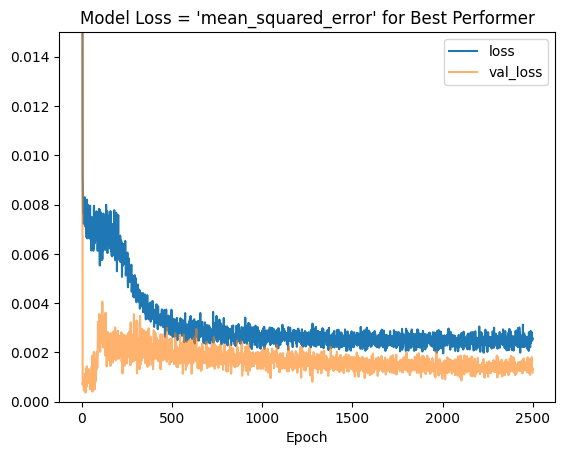

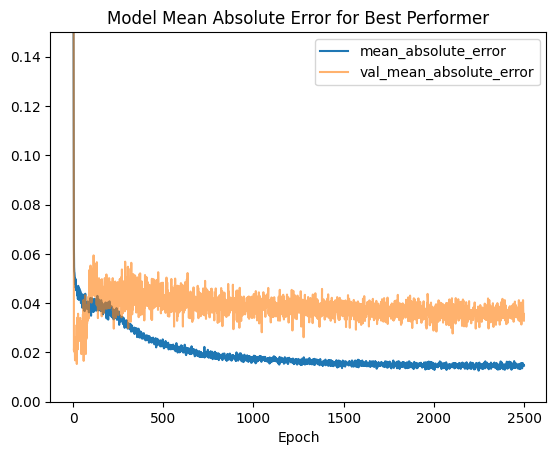

In [14]:
training_plots(model_history_file_path='/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/2024-04-17/2024-04-17-history/2024-04-17_lstm_model_history_27.json')

Prediction analysis

In [15]:
def prediction(
    model_path: str = None,
    raw_data_path: str = None,
    df: pd.DataFrame = None
    ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    
    """
    Predicts gold prices using a pre-trained LSTM model and evaluates the performance.

    This function loads a pre-trained LSTM model and uses it to predict gold prices on training,
    validation, and test datasets. It also evaluates the performance of the model by calculating
    the root mean squared error (RMSE) for each dataset.

    Parameters:
    model_path (str): Path to the pre-trained LSTM model file.
    raw_data_path (str): Path to the CSV file containing the raw gold price data.
    df (pd.DataFrame, optional): DataFrame containing the input data. If not provided, the function
                                 will call the data_prep() function to generate the DataFrame.

    Returns:
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: Returns three DataFrames containing the actual
                                                     and predicted values for the training, validation,
                                                     and test datasets, respectively.
    
    The function performs the following steps:
    1. Prepares the features by calling the feature_prep() function.
    2. Loads the pre-trained model from the specified model path.
    3. Generates predictions for the training, validation, and test datasets.
    4. Inverts the scaling of the predictions to obtain the actual predicted values.
    5. Splits the input DataFrame into training, validation, and test DataFrames.
    6. Adds the predictions to the test DataFrame.
    7. Sets the 'Date' column as the index for all three DataFrames.
    8. Calculates the root mean squared error (RMSE) for the training, validation, and test datasets.
    9. Prints the RMSE scores for each dataset.
    10. Returns the training, validation, and test DataFrames.

    Example:
    df_train, df_validation, df_test = prediction(
        model_path='/path/to/lstm_model.h5',
        df=your_dataframe
    )
    
    Note:
    Ensure that the functions `feature_prep`, `data_prep`, and `root_mean_squared_error` are defined
    and available in the scope where this function is called.
    """
    
    if model_path is None:
        raise ValueError("Model path must be provided")
    
    if df is None:
        if raw_data_path is None:
            raise ValueError("Raw data path must be provided")
    df = data_prep(raw_data_path = raw_data_path)
    
    Xtrain, ytrain, Xvalidation, yvalidation, Xtest, ytest, scaler, label_size, split_1, split_2 = feature_prep(df = df)
    
    model = load_model(model_path)
       
    #prediction
    train_predict = model.predict(Xtrain)
    validation_predict = model.predict(Xvalidation)
    test_predict = model.predict(Xtest)
    
    train_predict = np.c_[train_predict, np.zeros(train_predict.shape)]
    validation_predict = np.c_[validation_predict, np.zeros(validation_predict.shape)]
    test_predict = np.c_[test_predict, np.zeros(test_predict.shape)]

    #invert prediction
    train_predict = scaler.inverse_transform(train_predict)
    train_predict = [x[0] for x in train_predict]

    validation_predict = scaler.inverse_transform(validation_predict)
    validation_predict = [x[0] for x in validation_predict]

    test_predict = scaler.inverse_transform(test_predict)
    test_predict = [x[0] for x in test_predict]
    
    #data split into train and test
    n = label_size
    df_train = df[n:split_1]
    df_validation = df[split_1+n : split_2]
    df_test = df[split_2+n : len(df)]

    df_test['predictions'] = test_predict

    df_train.set_index('Date', inplace=True)
    df_validation.set_index('Date', inplace=True)
    df_test.set_index('Date', inplace=True)
    
    #calculate square root of mean squared error
    train_score = root_mean_squared_error(df_train['Close_gold'], train_predict)
    print('Train Score: %.2f RMSE [$]' % (train_score))

    validation_score = root_mean_squared_error(df_validation['Close_gold'], validation_predict)
    print('Validation Score: %.2f RMSE [$]' % (validation_score))

    test_score = root_mean_squared_error(df_test['Close_gold'], df_test['predictions'])
    print('Test Score: %.2f RMSE [$]' % (test_score))
    
    return df_train, df_validation, df_test

In [16]:
df_train, df_validation, df_test = prediction(model_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/2024-04-17/2024-04-17-models/2024-04-17_lstm_model_27.h5',
                                              raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train Score: 40.16 RMSE [$]
Validation Score: 79.57 RMSE [$]
Test Score: 120.13 RMSE [$]


/tmp/ipykernel_6272/2432710434.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions'] = test_predict


In [17]:
def plot_predictions(df_train: pd.DataFrame = None,
                     df_validation: pd.DataFrame = None,
                     df_test: pd.DataFrame = None,
                     model_path: str = None,
                     raw_data_path: str = None) -> None:
    """
    Plots the actual and predicted gold prices for the training, validation, and test datasets.

    Parameters:
    df_train (pd.DataFrame): DataFrame containing the actual and predicted values for the training dataset.
    df_validation (pd.DataFrame): DataFrame containing the actual and predicted values for the validation dataset.
    df_test (pd.DataFrame): DataFrame containing the actual and predicted values for the test dataset.
    model_path (str): Path to the pre-trained LSTM model file.
    raw_data_path (str): Path to the CSV file containing the raw gold price data.

    Returns:
    None
    """
    
    if df_train is None or df_validation is None or df_test is None:
        if model_path is None or raw_data_path is None:
            raise ValueError("Model path and raw data path must be provided")
            
        df_train, df_validation, df_test = prediction(model_path = model_path, raw_data_path = raw_data_path)
    
    #plot actual vs predicted values
    plt.figure(figsize=(16, 6))
    plt.plot(df_train.iloc[-(int(0.25*len(df_train))):]['Close_gold'], label='25% of Train')
    plt.plot(df_validation['Close_gold'], label='Validation')
    plt.plot(df_test['Close_gold'], label='Actual')
    plt.plot(df_test['predictions'], label='Forecast')
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.xticks(rotation=90)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.show()

148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train Score: 40.16 RMSE [$]
Validation Score: 79.57 RMSE [$]
Test Score: 120.13 RMSE [$]


/tmp/ipykernel_6272/2432710434.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions'] = test_predict


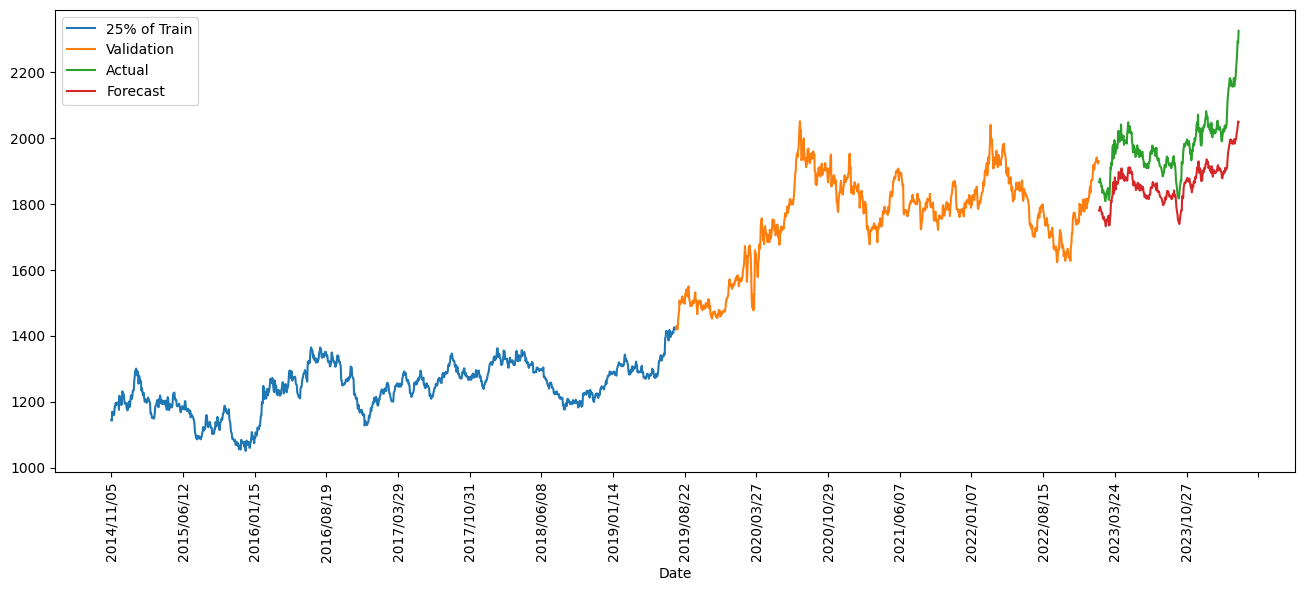

In [18]:
plot_predictions(model_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/2024-04-17/2024-04-17-models/2024-04-17_lstm_model_27.h5',
                 raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

Monte Carlo Simulation

In [59]:
def monte_carlo_sim(early_stopping: EarlyStopping = None,
                   iterations_summary: Optional[pd.DataFrame] = None,
                   lstm_nodes_1st_layer: int = 20,
                   lstm_nodes_2nd_layer: int = 30,
                   lstm_nodes_3rd_layer: int = 30,
                   dense_nodes: int = 20,
                   dropout_values: float = 0.05,
                   lstm_activation_func: str = 'tanh',
                   dense_activation_func: str = 'tanh',
                   learning_rate: float = 0.00005,
                   epochs: int = 5_000,
                   batch_size: int = 64,
                   input_shape: Tuple[int, int] = None,
                   iterations_num: int = 100,
                   raw_data_path: str = None) -> None:
    
    """
    Runs a Monte Carlo simulation to train an LSTM model for time series prediction multiple times with different initializations.

    Parameters:
    early_stopping (EarlyStopping, optional): Keras EarlyStopping callback to stop training when a monitored metric has stopped improving.
    iterations_summary (pd.DataFrame, optional): DataFrame to store the results of each iteration of the Monte Carlo simulation.
    lstm_nodes_1st_layer (int): Number of LSTM nodes in the first layer.
    lstm_nodes_2nd_layer (int): Number of LSTM nodes in the second layer.
    lstm_nodes_3rd_layer (int): Number of LSTM nodes in the third layer.
    dense_nodes (int): Number of nodes in the dense layer.
    dropout_values (float): Dropout rate for regularization in the LSTM layers.
    lstm_activation_func (str): Activation function for the LSTM layers.
    dense_activation_func (str): Activation function for the dense layer.
    learning_rate (float): Learning rate for the optimizer.
    epochs (int): Number of epochs to train each model.
    batch_size (int): Batch size for training.
    input_shape (Tuple[int, int], optional): Shape of the input data.
    iterations_num (int): Number of Monte Carlo iterations to perform.

    Returns:
    None

    This function prepares the data and iteratively trains an LSTM model using the specified parameters. Each iteration involves:
    1. Building a new LSTM model with the given architecture and hyperparameters.
    2. Training the model on the training data and validating on the validation data.
    3. Saving the trained model and its training history.
    4. Recording the training and validation metrics in the iterations_summary DataFrame.
    5. Saving the iterations_summary DataFrame to a CSV file.

    The early stopping callback is configured to monitor the validation loss and stop training if there is no improvement after a certain number of epochs.
    """
    
    if raw_data_path is None:
        raise ValueError("Raw data file path must be provided")

    # Data preparation
    Xtrain, ytrain, Xvalidation, yvalidation, Xtest, ytest, scaler, label_size, split_1, split_2 = feature_prep(raw_data_path = raw_data_path)
    
    if input_shape is None:
        input_shape = (Xtrain.shape[1], Xtrain.shape[2])
    validation_data = (Xvalidation, yvalidation)
    
    if early_stopping is None:
        early_stopping = EarlyStopping(monitor='val_loss', patience=500, verbose=1, restore_best_weights=True, start_from_epoch=1_500)
    if iterations_summary is None:
        iterations_summary = pd.DataFrame(columns = ['iteration', 'loss', 'val_loss', 'mean_squared_error','val_mean_squared_error',
                                                     'mean_absolute_error', 'val_mean_absolute_error', 'stopped_epoch'])
    
    time_stamp = datetime.now().strftime('%Y-%m-%d')
    model_base_path = f'/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/{time_stamp}-monte-carlo'
    
    for iteration in range(iterations_num):
        
        model = build_3l_model(lstm_nodes_1=lstm_nodes_1st_layer, lstm_nodes_2=lstm_nodes_2nd_layer, lstm_nodes_3=lstm_nodes_3rd_layer,
                               dense_nodes_1=dense_nodes, input_shape=input_shape,
                               dropout=dropout_values, activation_lstm=lstm_activation_func, activation_dense=dense_activation_func, learning_rate=learning_rate)
        
        fitt_model = model.fit(Xtrain, ytrain, batch_size = batch_size, epochs = epochs, validation_data = validation_data,
                               verbose = 0, callbacks = [early_stopping])
        
        stopped_epoch = early_stopping.stopped_epoch        
        
        #save model
        models_folder_path = f'{model_base_path}/{time_stamp}-models'
        os.makedirs(models_folder_path, exist_ok = True)
        model_files_path = f'{models_folder_path}/{time_stamp}_lstm_model_monte_carlo_{iteration}.keras'
        model.save(model_files_path)
                         
        #save model history
        model_history = fitt_model.history
        history_folder_path = f'{model_base_path}/{time_stamp}-history'
        os.makedirs(history_folder_path, exist_ok = True)
                                
        history_files_path = f'{history_folder_path}/{time_stamp}_lstm_model_history_{iteration}.json'
        with open(history_files_path, 'w') as json_file:
            json.dump(model_history, json_file)
                                                                
        iteration_row = {'iteration': iteration,
                      'loss': fitt_model.history['loss'][-1],
                      'val_loss': fitt_model.history['val_loss'][-1],
                      'mean_squared_error': fitt_model.history['mean_squared_error'][-1],
                      'val_mean_squared_error': fitt_model.history['val_mean_squared_error'][-1],
                      'mean_absolute_error': fitt_model.history['mean_absolute_error'][-1],
                      'val_mean_absolute_error': fitt_model.history['val_mean_absolute_error'][-1],
                      'stopped_epoch': stopped_epoch}
                                   
        iterations_summary.loc[iteration] = iteration_row
    
    iterations_summary.to_csv(f'{model_base_path}/{time_stamp}_lstm_iterations_summary.csv', index = False)      

In [ ]:
monte_carlo_sim(early_stopping = None,
                iterations_summary = None,
                lstm_nodes_1st_layer = 20,
                lstm_nodes_2nd_layer = 30,
                lstm_nodes_3rd_layer = 30,
                dense_nodes = 20,
                dropout_values = 0.05,
                lstm_activation_func = 'tanh',
                dense_activation_func = 'tanh',
                learning_rate = 0.00005,
                epochs = 5_000,
                batch_size = 64,
                input_shape = None,
                iterations_num = 100,
                raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

Monte Carlo Sim Analysis

In [19]:
models_summary_df = pd.read_csv('/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/2024-04-27-2-monte-carlo/2024-04-27_lstm_iterations_summary.csv')
models_summary_df.head()

,iteration,loss,val_loss,mean_squared_error,val_mean_squared_error,mean_absolute_error,val_mean_absolute_error,stopped_epoch
0,0,0.002653,0.001426,0.002653,0.001426,0.015524,0.036230,4175
1,1,0.002704,0.001780,0.002704,0.001780,0.018019,0.039808,1999
2,2,0.002738,0.001921,0.002738,0.001921,0.019486,0.041326,1999
3,3,0.002329,0.002254,0.002329,0.002254,0.018419,0.045051,1999
4,4,0.002752,0.001788,0.002752,0.001788,0.018544,0.040338,1999


In [65]:
def normality_test(models_summary_df: pd.DataFrame,
                   test: str = 'normaltest',
                   data: str = 'mean_squared_error',
                   pv_threshold: float = 0.05) -> None:
    """
    Performs a normality test on the specified data column of the provided DataFrame.

    Parameters:
    models_summary_df (pd.DataFrame): DataFrame containing the data to test.
    test (str): Type of normality test ('normaltest', 'shapiro-wilk', 'anderson'). Default is 'normaltest'.
    data (str): Column name of the data to test. Default is 'mean_squared_error'.
    pv_threshold (float): p-value threshold for significance. Default is 0.05.

    Returns:
    None
    """
    
    print('p_value threshold: {0}'.format(pv_threshold))
    print('(not applicable to Anderson test)')
    print('p_value for Anderson test: 0.05')
    print(100 * '-')
    
    if data not in models_summary_df.columns:
        print(f"Column '{data}' not found in the DataFrame.")
        return
    
    description = ''
    
    if test == 'normaltest':
        pv = stats.normaltest(models_summary_df[data])[1]
        description = '(normaltest is based on D’Agostino and Pearson’s test)'
    elif test == 'shapiro-wilk':
        pv = stats.shapiro(models_summary_df[data])[1]
        description = '(Shapiro-Wilk test is based on the correlation ratio)'
    elif test == 'anderson':
        result = stats.anderson(models_summary_df[data], dist='norm')
        statistic = result.statistic
        pv_5 = result.critical_values[2]
        success = pv_5 > statistic
        description = '(Anderson-Darling test is based on the kurtosis and skewness of the data)'
    else:
        print(f"Unknown test type: {test}")
        return

    if test != 'anderson':
        if pv < pv_threshold:
            print(f'p_value for {data}: {round(pv, 4)}')
            print(f'{data} is not normally distributed based on {test}')
        else:
            print(f'p_value for {data}: {round(pv, 4)}')
            print(f'{data} is normally distributed based on {test}')
            print(100 * '-')
            mean = round(models_summary_df[data].mean(), 4)
            std = round(models_summary_df[data].std(), 4)
            print(f'mean: {mean}')
            print(f'standard deviation: {std}')
    else:
        if success:
            print(f'{data} is normally distributed based on {test}')
        else:
            print(f'{data} is not normally distributed based on {test}')
        print(description)
        print(100 * '-')
        mean = round(models_summary_df[data].mean(), 4)
        std = round(models_summary_df[data].std(), 4)
        print(f'mean: {mean}')
        print(f'standard deviation: {std}')
    
    print(100 * '-')

In [66]:
def pdf_plot(models_summary_df, results='mean_squared_error', training_bins=20, val_bins=20, training_distr='norm', val_distr='norm') -> plt.Figure:
    def plot_distribution(data, bins, color, label, distr):
        ax.hist(data, bins=bins, density=True, alpha=0.6, color=color, edgecolor='black', label=f'{label} histogram')
        if distr == 'norm':
            params = stats.norm.fit(data)
            x = np.linspace(data.min(), data.max(), 100)
            p = stats.norm.pdf(x, *params)
            ax.plot(x, p, color=color, linewidth=2, label=f'{label} pdf')
            ax.axvline(params[0], color=color, linestyle='dashed', linewidth=1, label=f'{label} mean')
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    plot_distribution(models_summary_df[results], training_bins, 'g', 'training', training_distr)
    plot_distribution(models_summary_df[f'val_{results}'], val_bins, 'b', 'validation', val_distr)
    
    ax.set_title(f'Training vs Validation Results of {results}')
    ax.legend()
    
    return fig

p_value threshold: 0.05
(not applicable to Anderson test)
p_value for Anderson test: 0.05
----------------------------------------------------------------------------------------------------
p_value for mean_squared_error: 0.1386
mean_squared_error is normally distributed based on shapiro-wilk
----------------------------------------------------------------------------------------------------
mean: 0.0027
standard deviation: 0.0002
----------------------------------------------------------------------------------------------------
p_value threshold: 0.05
(not applicable to Anderson test)
p_value for Anderson test: 0.05
----------------------------------------------------------------------------------------------------
p_value for val_mean_squared_error: 0.2839
val_mean_squared_error is normally distributed based on shapiro-wilk
----------------------------------------------------------------------------------------------------
mean: 0.0019
standard deviation: 0.0003
-------------------

/tmp/ipykernel_114442/1906324882.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


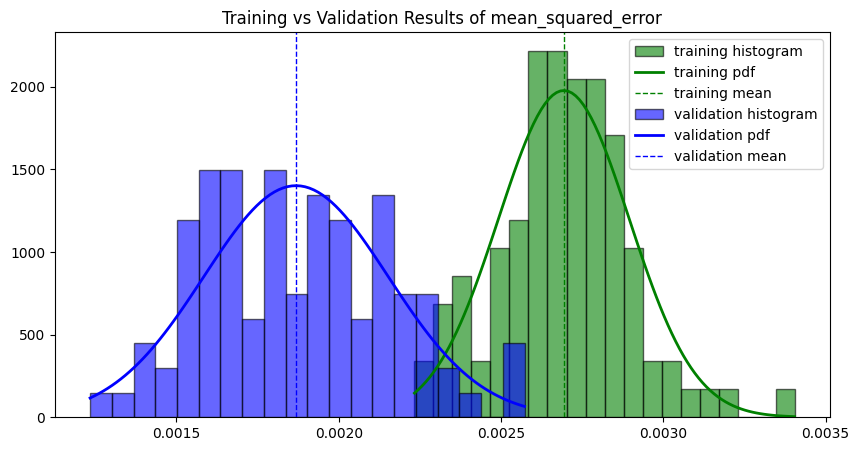

In [67]:
normality_test(models_summary_df, test = 'shapiro-wilk', data = 'mean_squared_error', pv_threshold = 0.05)
normality_test(models_summary_df, test = 'shapiro-wilk', data = 'val_mean_squared_error', pv_threshold = 0.05)
fig = pdf_plot(models_summary_df, results='mean_squared_error', training_bins=20, val_bins=20, training_distr='norm', val_distr='norm')
fig.show()

p_value threshold: 0.05
(not applicable to Anderson test)
p_value for Anderson test: 0.05
----------------------------------------------------------------------------------------------------
p_value for mean_absolute_error: 0.0008
mean_absolute_error is not normally distributed based on shapiro-wilk
----------------------------------------------------------------------------------------------------
p_value threshold: 0.05
(not applicable to Anderson test)
p_value for Anderson test: 0.05
----------------------------------------------------------------------------------------------------
p_value for val_mean_absolute_error: 0.5363
val_mean_absolute_error is normally distributed based on shapiro-wilk
----------------------------------------------------------------------------------------------------
mean: 0.0407
standard deviation: 0.0034
----------------------------------------------------------------------------------------------------


/tmp/ipykernel_114442/439164075.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


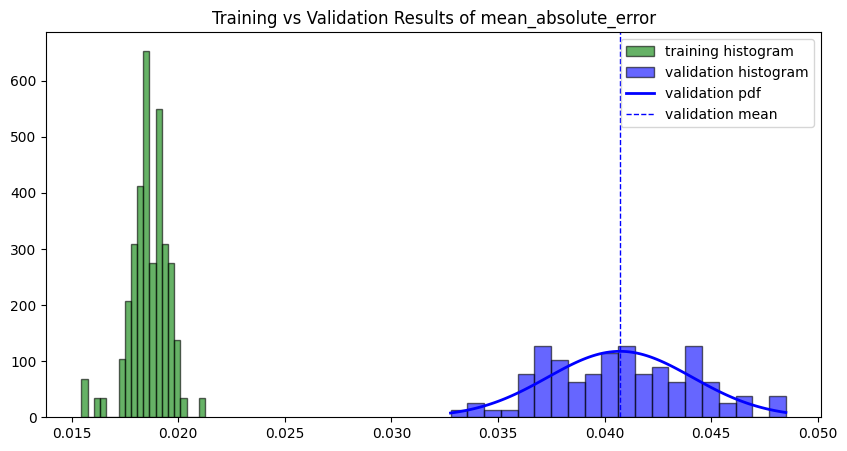

In [68]:
normality_test(models_summary_df, test = 'shapiro-wilk', data = 'mean_absolute_error', pv_threshold = 0.05)
normality_test(models_summary_df, test = 'shapiro-wilk', data = 'val_mean_absolute_error', pv_threshold = 0.05)
fig = pdf_plot(models_summary_df, results='mean_absolute_error', training_bins=20, val_bins=20, training_distr='not-norm', val_distr='norm')
fig.show()

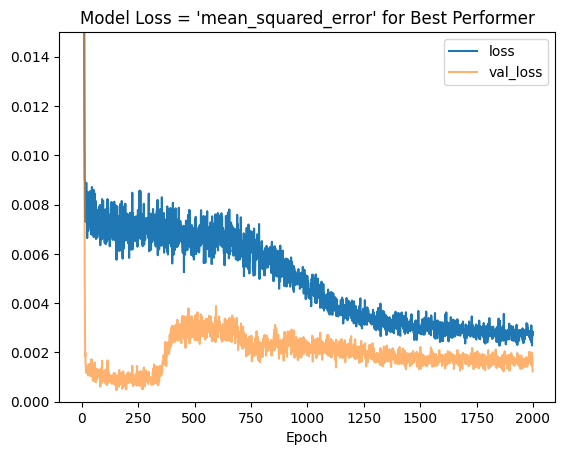

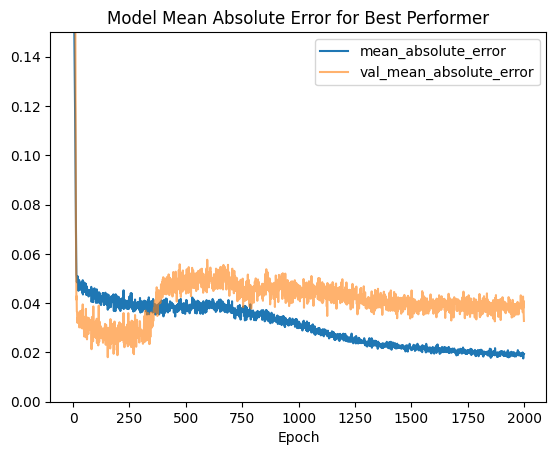

In [69]:
training_plots(model_history_file_path='/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/2024-04-27-2-monte-carlo/2024-04-27-history/2024-04-27_lstm_model_history_28.json')

In [74]:
def monte_carelo_sim_prediction_results(
    origin_path: str = None,
    predictions_df: pd.DataFrame = None,
    raw_data_path: str = None
    ) -> Tuple[pd.DataFrame, int]:

    """
    Perform Monte Carlo simulations using LSTM models to predict gold prices.

    Parameters:
        origin_path (str): The directory containing the LSTM models.
        predictions_df (pd.DataFrame, optional): DataFrame to store predictions. If None, a new DataFrame is created.
        raw_data_path (str): Path to the CSV file containing the raw gold price data.

    Returns:
        Tuple[pd.DataFrame, int]: A DataFrame with test predictions and the number of models used.
    """
    
    if origin_path is None:
        raise ValueError("Models folder path must be provided")

    #number of models
    try:
        files_no = len(os.listdir(origin_path))
    except FileNotFoundError:
        raise FileNotFoundError('Directory not found.')
    
    if raw_data_path is None:
        raise ValueError("Raw data file path must be provided")

    # Data preparation
    Xtrain, ytrain, Xvalidation, yvalidation, Xtest, ytest, scaler, label_size, split_1, split_2 = feature_prep(raw_data_path = raw_data_path)
    
    if predictions_df is None:
        predictions_df = pd.DataFrame()
        
    #predictions
    for model_no in range(files_no):
        path = origin_path + '/{0}_lstm_model_monte_carlo_{1}.keras'.format(origin_path.split('/')[-1][0:10], model_no)
    
        try:
            model = load_model(path)
        except Exception as e:
            print('Error loading model: {0}'.format(e))
            continue
        
        #prediction
        train_predict = model.predict(Xtrain)
        validation_predict = model.predict(Xvalidation)
        test_predict = model.predict(Xtest)

        train_predict = np.c_[train_predict, np.zeros(train_predict.shape)]
        validation_predict = np.c_[validation_predict, np.zeros(validation_predict.shape)]
        test_predict = np.c_[test_predict, np.zeros(test_predict.shape)]

        #invert prediction
        train_predict = scaler.inverse_transform(train_predict)
        train_predict = [x[0] for x in train_predict]

        validation_predict = scaler.inverse_transform(validation_predict)
        validation_predict = [x[0] for x in validation_predict]

        test_predict = scaler.inverse_transform(test_predict)
        test_predict = [x[0] for x in test_predict]
        
        predictions_df['test_predict_{0}'.format(model_no)] = test_predict
        
    return predictions_df, files_no

In [75]:
predictions_df, files_no = monte_carelo_sim_prediction_results(origin_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/2024-04-27-2-monte-carlo/2024-04-27-models',
                                                               raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/s

148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train Score: 38.16 RMSE [$]
Validation Score: 69.11 RMSE [$]
Test Score: 111.41 RMSE [$]


/tmp/ipykernel_114442/2432710434.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions'] = test_predict


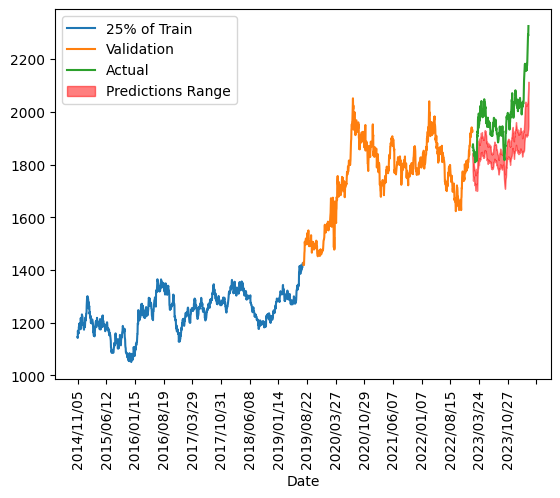

In [76]:
df_train, df_validation, df_test = prediction(model_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/2024-04-27-2-monte-carlo/2024-04-27-models/2024-04-27_lstm_model_monte_carlo_0.keras',
                                              raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

list_of_columns = predictions_df.columns.tolist()
df_test = df_test.reset_index()
df_test = pd.concat([df_test, predictions_df], axis=1)
df_test = df_test.set_index('Date')

df_test['min_predict'] = df_test[list_of_columns].min(axis=1)
df_test['max_predict'] = df_test[list_of_columns].max(axis=1)

#plot actual vs predicted values

plt.plot(df_train.iloc[-(int(0.25*len(df_train))):]['Close_gold'], label='25% of Train')
plt.plot(df_validation['Close_gold'], label='Validation')
plt.plot(df_test['Close_gold'], label='Actual')

plt.fill_between(df_test.index, df_test['min_predict'], df_test['max_predict'], color='r', alpha=0.5, label='Predictions Range')

plt.legend(loc='upper left')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.show();

Additional model training and analysis

In [ ]:
#5th training
model_training(early_stopping = EarlyStopping(monitor = 'val_loss', patience = 500, verbose = 1, restore_best_weights = True, start_from_epoch = 1_500),
               models_summary = None,
               lstm_nodes_1st_layer = [20],
               lstm_nodes_2nd_layer = [30],
               lstm_nodes_3rd_layer = [30],
               lstm_nodes_4th_layer = None,
               dense_nodes = [20],
               dropout_values = [0.05, 0.1, 0.2],
               lstm_activation_func = ['tanh'],
               dense_activation_func = ['tanh'],
               learning_rate = [0.001],
               epochs = 5_000,
               batch_size = 64,
               input_shape = (Xtrain.shape[1], Xtrain.shape[2]),
               base_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models',
               raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

In [77]:
models_summary_df = pd.read_csv('/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/2024-05-19/2024-05-19_lstm_models_summary.csv')
models_summary_df

,model_no,dropout,loss,val_loss,mean_squared_error,val_mean_squared_error,mean_absolute_error,val_mean_absolute_error,stopped_epoch,best_performer
0,1,0.05,0.002540,0.001817,0.002540,0.001817,0.014182,0.041248,2222,yes
1,2,0.10,0.005085,0.005327,0.005085,0.005327,0.024253,0.072076,1999,no
2,3,0.20,0.009599,0.022522,0.009599,0.022522,0.042580,0.149197,1999,no


In [78]:
models_summary_df[models_summary_df['stopped_epoch'] == models_summary_df['stopped_epoch'].max()]

,model_no,dropout,loss,val_loss,mean_squared_error,val_mean_squared_error,mean_absolute_error,val_mean_absolute_error,stopped_epoch,best_performer
0,1,0.05,0.00254,0.001817,0.00254,0.001817,0.014182,0.041248,2222,yes


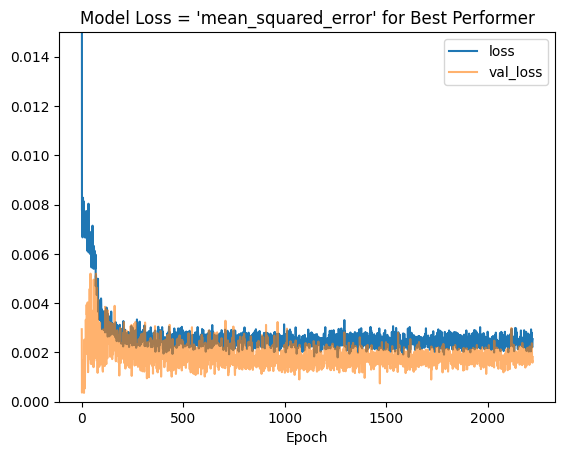

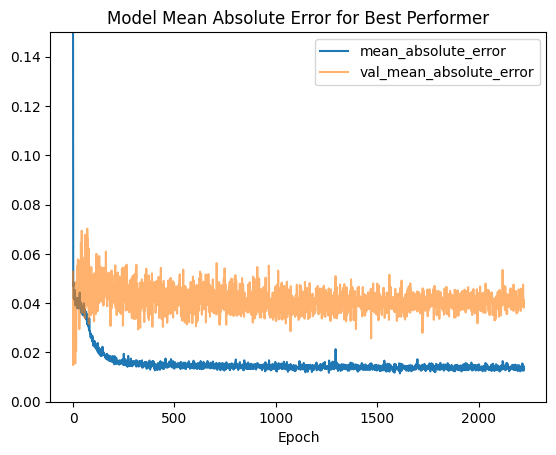

In [79]:
training_plots(model_history_file_path='/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/2024-05-19/2024-05-19-history/2024-05-19_lstm_model_history_1.json')

In [81]:
models_dir = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/2024-05-19/2024-05-19-models'

models_no = len(os.listdir(models_dir))
prediction_results = pd.DataFrame()

for model in range(1, models_no+1):
    
    print(f'Prediction for model {model}')
    
    df_train, df_validation, df_test = prediction(model_path = f'/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/models/2024-05-19/2024-05-19-models/2024-05-19_lstm_model_{model}.h5',
                                              raw_data_path = '/home/kssocha/Desktop/Nauka/portfolio/2024-gold-price-prediction-with-lstm-model/data/raw/2024-04-06_09:28_yf_au_data_.csv')

    prediction_results[f'prediction_{model}'] = df_test['predictions']

    print(100*'-')

Prediction for model 1


148/148 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train Score: 33.54 RMSE [$]
Validation Score: 62.15 RMSE [$]
Test Score: 124.59 RMSE [$]
----------------------------------------------------------------------------------------------------
Prediction for model 2


/tmp/ipykernel_114442/2432710434.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions'] = test_predict


148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Train Score: 84.68 RMSE [$]
Validation Score: 159.64 RMSE [$]
Test Score: 200.16 RMSE [$]
----------------------------------------------------------------------------------------------------
Prediction for model 3


/tmp/ipykernel_114442/2432710434.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions'] = test_predict


148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train Score: 162.18 RMSE [$]
Validation Score: 295.74 RMSE [$]
Test Score: 342.98 RMSE [$]
----------------------------------------------------------------------------------------------------


/tmp/ipykernel_114442/2432710434.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predictions'] = test_predict


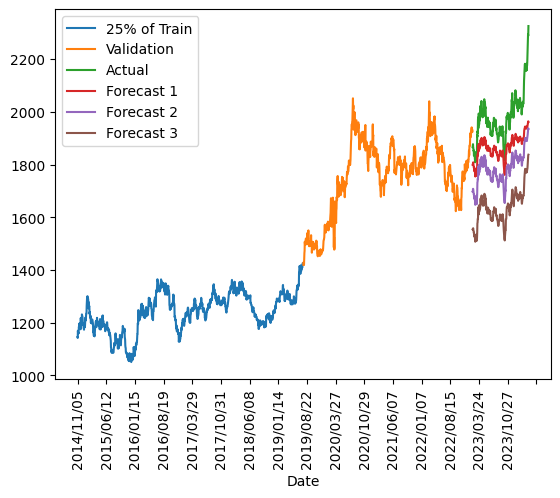

In [82]:
#plot actual vs predicted values
plt.plot(df_train.iloc[-(int(0.25*len(df_train))):]['Close_gold'], label='25% of Train')
plt.plot(df_validation['Close_gold'], label='Validation')
plt.plot(df_test['Close_gold'], label='Actual')

for prediction in range(1, models_no +1):
    plt.plot(prediction_results[f'prediction_{prediction}'], label=f'Forecast {prediction}')

plt.legend(loc='upper left')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.show();